# Classification dog and cat using PyTorch from scratch
* [x] Original source: https://www.kaggle.com/c/dogs-vs-cats/data?select=train.zip
* [x] full Dataset: https://www.kaggle.com/datasets/salader/dogs-vs-cats
* [x] Download dataset by click on this link https://www.kaggle.com/datasets/salader/dogs-vs-cats/download?datasetVersionNumber=1
* [x] And download with key `kaggle competitions download -c dogs-vs-cats`

# Step by Step
1. Download dataset from https://www.kaggle.com/datasets/salader/dogs-vs-cats/download?datasetVersionNumber=1 into `data/dogvscat/`
2. Pre-processing data from dataset.
3. Create `DogandCatDataset` class to get image and transformed_image.
4. Push data to Dataloader and Testing `DogandCatDataset` class.
5. Create TinyVGG Neural Network.
6. Create `train_step()`, `test_step()` and `train()` to train model.
7. Visualize training and testing processing.
8. Make predict and visualize it.
9. Upgrade model if the results aren't good.

## Step 1: Download dataset

In [ ]:
!pip install -q kaggle

In [ ]:
import os
from pathlib import Path
import zipfile
import requests
import shutil
# Setup path
root_path = Path('./data')
root_image_path = root_path / "dogvscat"

if not root_image_path.is_dir():
  print(f'Creating directory {root_image_path}...')
  root_image_path.mkdir(parents=True, exist_ok=True)

zipfile_path = root_path / 'dogvscat.zip'
# if not zipfile_path.is_file():
  # Download data
request = requests.get('https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip')
with open(zipfile_path, 'wb') as f:
  print(f'Downloading {zipfile_path}...')
  f.write(request.content)

# Unzip data
with zipfile.ZipFile(zipfile_path, 'r') as zip_ref:
  print(f'Unzipping {zipfile_path}...')
  zip_ref.extractall(root_image_path)

train_path = root_image_path / 'train'
validation_path = root_image_path / 'validation'
shutil.move(root_image_path / 'cats_and_dogs_filtered/train', train_path)
shutil.move(root_image_path / 'cats_and_dogs_filtered/validation', validation_path)
# remove root_image_path / 'cats_and_dogs_filtered/'
shutil.rmtree(root_image_path / 'cats_and_dogs_filtered')
print('Data downloaded and extracted successfully.')

Creating directory data/dogvscat...
Unzipping data/dogvscat.zip...
Data downloaded and extracted successfully.


## Step 2: Pre-processing dataset

In [ ]:
import os

def walk_through_dir(dir_path):
  image_paths = []
  for dirpath, dirnames, filenames in os.walk(dir_path):
    if filenames:
      print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
      for filename in filenames:
        path = os.path.join(dirpath, filename)
        image_paths.append(path)
  return image_paths
image_path_list = walk_through_dir(root_image_path)

There are 0 directories and 500 images in 'data/dogvscat/validation/cats'.
There are 0 directories and 500 images in 'data/dogvscat/validation/dogs'.
There are 0 directories and 1000 images in 'data/dogvscat/train/cats'.
There are 0 directories and 1000 images in 'data/dogvscat/train/dogs'.


In [ ]:
len(image_path_list)

3000

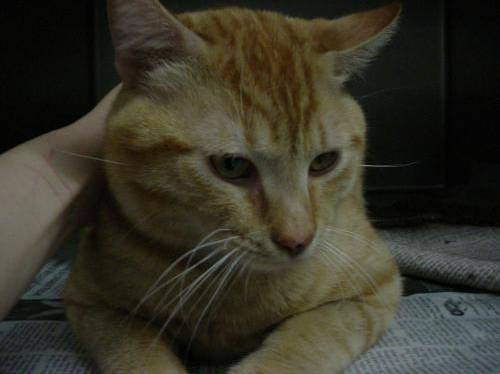

In [ ]:
from PIL import Image

image = Image.open(image_path_list[1])
image

## Step 3: Create `DogsvsCatsDataset` class

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import os

class DogsvsCatsDataset(Dataset):
  def __init__(self, tar_dir, transform : transforms =None):

    self.image_paths = self._walk_through_dir(tar_dir)
    self.classes, self.cls_to_idx = self._find_classes(tar_dir)
    self.transform = transform

  def _walk_through_dir(self, tar_dir):
    dir_paths = [dir_path for dir_path, _, filenames in os.walk(tar_dir) if filenames]
    image_paths = []
    for path in dir_paths:
     image_paths += Path(path).glob("*.jpg")
    return image_paths

  def _find_classes(self, tar_dir):

    classes = sorted(entry.name for entry in os.scandir(tar_dir) if entry.is_dir())
    if not classes:
      raise FileNotFoundError(f"Couldn't find any class name, please check your target path!")
    cls_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, cls_to_idx

  def _load_image(self, index):
    image = Image.open(self.image_paths[index])
    return image

  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, index):
    image = self._load_image(index)
    class_name = self.image_paths[index].parent.stem
    cls_to_idx = self.cls_to_idx[class_name]

    if self.transform:
      return self.transform(image), cls_to_idx
    return image, cls_to_idx


## Step 4: Push data to Dataloader and Testing `DogandCatDataset` class.

In [ ]:
train_dir = root_image_path / 'train'
test_dir = root_image_path / 'validation'
train_dir, test_dir

(PosixPath('data/dogvscat/train'), PosixPath('data/dogvscat/validation'))

In [ ]:
transformer = transforms.Compose([
    transforms.Resize(size=(256,256)),
    transforms.CenterCrop(size=(224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
train_data = DogsvsCatsDataset(train_dir, transformer)
test_data = DogsvsCatsDataset(test_dir, transformer)

(-0.5, 223.5, 223.5, -0.5)

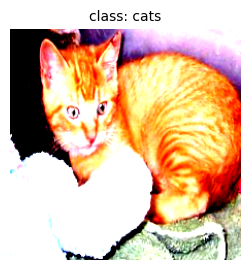

In [ ]:
import matplotlib.pyplot as plt

random_idx = torch.randint(0, len(train_data), size=[1]).item()

image, cls_to_idx = train_data[random_idx]
class_name = train_data.classes[cls_to_idx]

plt.figure(figsize=(3,3))
plt.imshow(image.permute(1,2,0))
plt.title(f'class: {class_name}', fontsize=10)
plt.axis(False)

train_dataloader: 63 batches of 32
test_dataloader: 32 batches of 32


images shape: torch.Size([32, 3, 224, 224])
labels shape: torch.Size([32])


(-0.5, 223.5, 223.5, -0.5)

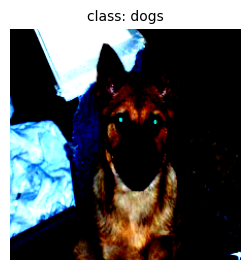

In [ ]:
from torch.utils.data import DataLoader

batch_size = 32
num_workers = 0

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)

print(f'train_dataloader: {len(train_dataloader)} batches of {batch_size}')
print(f'test_dataloader: {len(test_dataloader)} batches of {batch_size}')

images, labels = next(iter(train_dataloader))

print(f'images shape: {images.shape}')
print(f'labels shape: {labels.shape}')

plt.figure(figsize=(3,3))
plt.imshow(images[0].permute(1,2,0))
plt.title(f'class: {train_data.classes[labels[0]]}', fontsize=10)
plt.axis(False)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [ ]:
!pip install -q torchinfo

## Step 6: Create train_step(), test_step() and train() to train model.

In [ ]:
def train_step(model, train_dataloader, optimizer, loss_fn, device):
  model.train()

  train_loss, train_acc = 0, 0
  for batch, (X, y) in enumerate(train_dataloader):
    X, y = X.to(device), y.to(device)

    # Forward pass
    y_pred = model(X)
    # Loss calculate
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()
    correct = torch.eq(torch.argmax(torch.softmax(y_pred, dim=1), dim=1), y).sum().item()
    train_acc += (correct / len(y))
    # Backward
    optimizer.zero_grad()
    loss.backward()
    # Update weights
    optimizer.step()
    # if (batch+1) % 20 == 0:
    #   print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

  train_loss /= len(train_dataloader)
  train_acc /= len(train_dataloader)
  return train_loss, train_acc

In [ ]:
def test_step(model, test_dataloader, loss_fn, device):
  model.eval()

  with torch.inference_mode():
    test_loss, test_acc = 0, 0
    for X, y in test_dataloader:
      X, y = X.to(device), y.to(device)
      y_pred = model(X)
      loss = loss_fn(y_pred, y)
      test_loss += loss.item()
      correct = torch.eq(torch.argmax(torch.softmax(y_pred, dim=1), dim=1), y).sum().item()
      test_acc += (correct / len(y))

    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)
  return test_loss, test_acc

In [ ]:
from pathlib import Path
def save_model(model, tar_dir='./models', filename='model.pth'):
  tar_dir = Path(tar_dir)
  tar_dir.mkdir(parents=True, exist_ok=True)
  save_path = tar_dir / filename
  torch.save(obj=model.state_dict(), f=save_path)
  print(f'Model saved to {save_path}')

In [ ]:
from tqdm import tqdm
from timeit import default_timer as timer

def train(model, epochs, lr, train_dataloader, test_dataloader, device):
  # Create loss_fn and optimizer
  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.AdamW(params=model.parameters(), lr=lr)

  results = {
      'train_loss': [],
      'train_acc': [],
      'test_loss': [],
      'test_acc': [],
      'time_train': 0,
      "model_name": model.__class__.__name__,
      'device': device
  }
  start_train = timer()
  best_acc_idx = 0
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model, train_dataloader, optimizer, loss_fn, device)
    test_loss, test_acc = test_step(model, test_dataloader, loss_fn, device)
    results['train_loss'].append(train_loss)
    results['train_acc'].append(train_acc)
    results['test_loss'].append(test_loss)
    results['test_acc'].append(test_acc)

    if test_acc > results['test_acc'][best_acc_idx]:
        save_model(model, filename=f'{model.__class__.__name__}.pth')
        best_acc_idx = epoch

    if test_acc > 0.95 and train_acc > 0.95:
      break

    if epoch % 10 == 0:
      print(f'Epoch: {epoch} | train_loss: {train_loss:.3f} | train_acc: {train_acc:.3f} | test_loss: {test_loss:.3f} | test_acc: {test_acc:.3f}')


  end_train = timer()
  results['time_train'] = end_train - start_train
  print(f'\nTime train {model.__class__.__name__} on {device} is {end_train - start_train} seconds')
  return results

## Step 7: Visualize training and testing processing.

In [ ]:
def plot_training_and_testing_results(results):
  train_loss = results['train_loss']
  train_acc = results['train_acc']
  test_loss = results['test_loss']
  test_acc = results['test_acc']

  epochs = range(len(train_loss))

  plt.figure(figsize=(10,7))
  plt.suptitle(f'Time train {results["model_name"]} on {results["device"]} in {epochs[-1] + 1} epochs is {results["time_train"]:.3f} seconds', fontsize=15)

  plt.subplot(1,2,1)
  plt.plot(epochs, train_loss, label='train_loss')
  plt.plot(epochs, test_loss, label='test_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()
  plt.grid(True)

  plt.subplot(1,2,2)
  plt.plot(epochs, train_acc, label='train_acc')
  plt.plot(epochs, test_acc, label='test_acc')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()
  plt.grid(True)

  plt.tight_layout()
  plt.show()


## Step 8: Make predict and visualize it.

In [ ]:
import requests
from PIL import Image
def download_image(url, file_name):
  print(f'Downloading {file_name}...')
  request = requests.get(url)
  with open(file_name, 'wb') as f:
    f.write(request.content)
  return Image.open(file_name)

In [ ]:
def make_predict(model, image, transformer, device):
  model.eval()
  model = model.to(device)
  transformed_image = transformer(image).unsqueeze(0).to(device)
  with torch.inference_mode():
    y_pred = model(transformed_image).to(device)
    prob = torch.softmax(y_pred, dim=1).cpu().max().item()
    cls_to_idx = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    class_name = train_data.classes[cls_to_idx]
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    plt.title(f'class: {class_name} | prob: {prob:.3f}', fontsize=15)
    plt.axis(False)

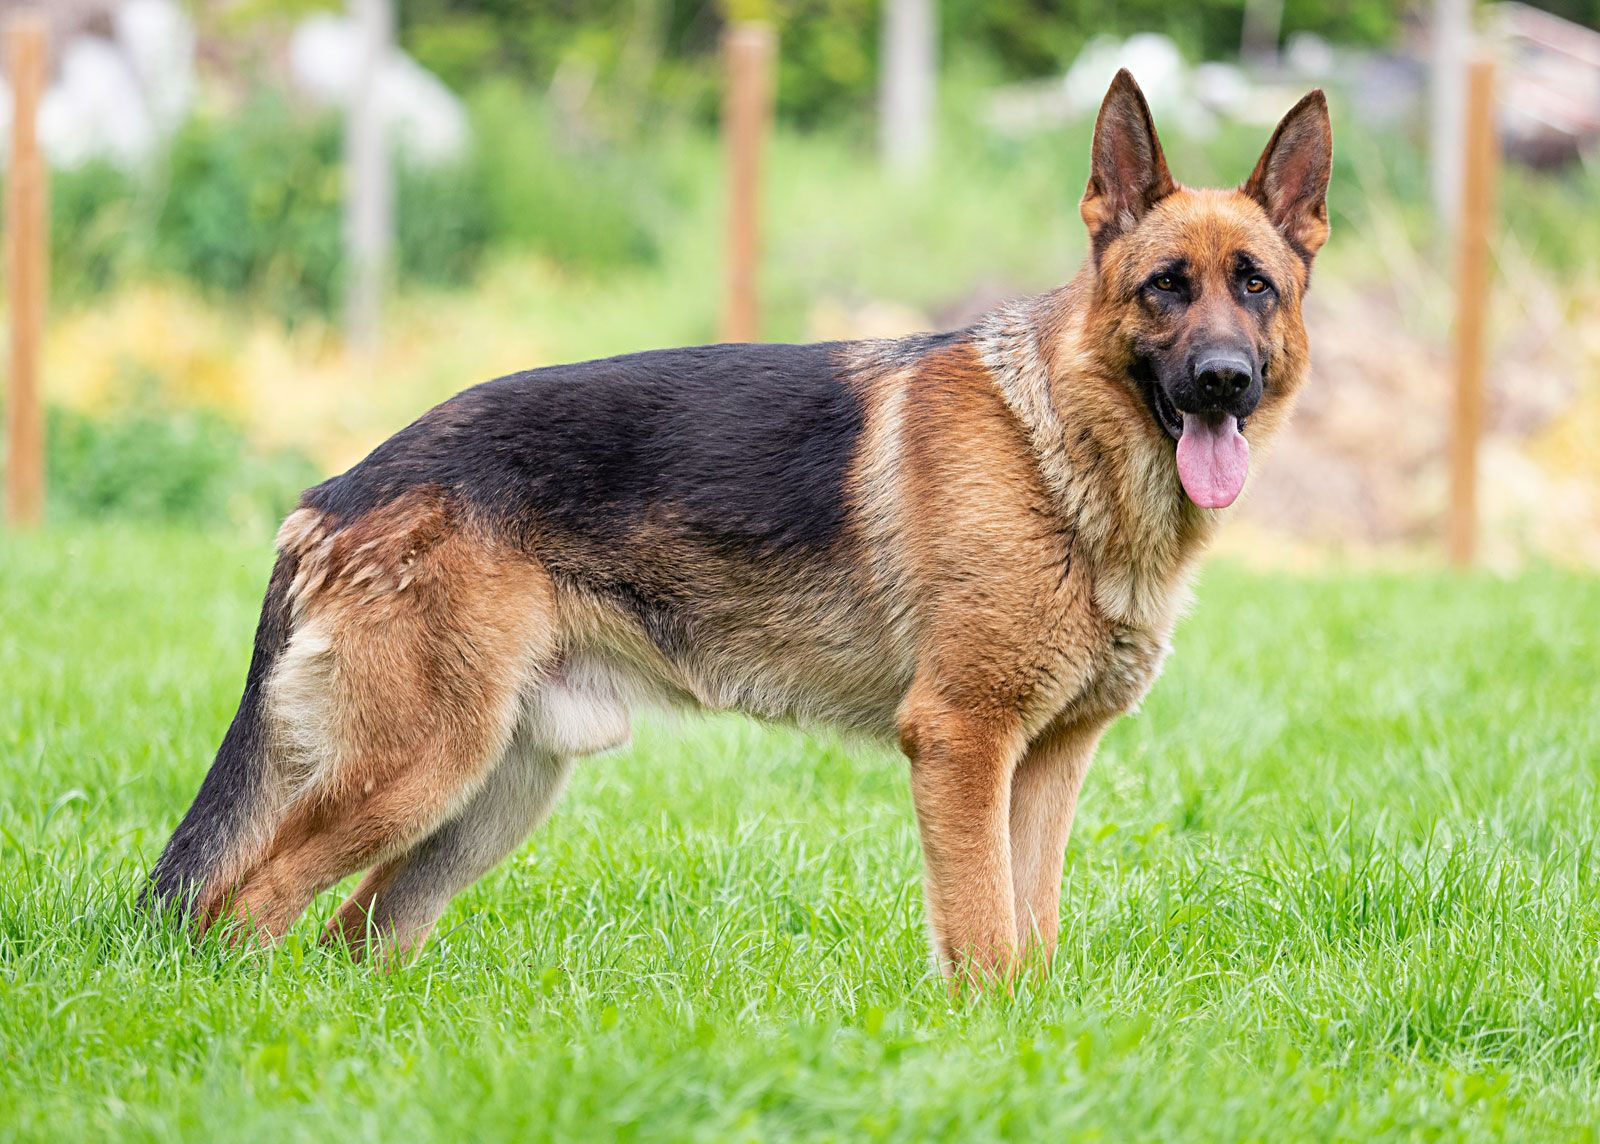

In [ ]:
dog_image = download_image(url="https://cdn.britannica.com/79/232779-050-6B0411D7/German-Shepherd-dog-Alsatian.jpg", file_name='dog.jpg')
dog_image

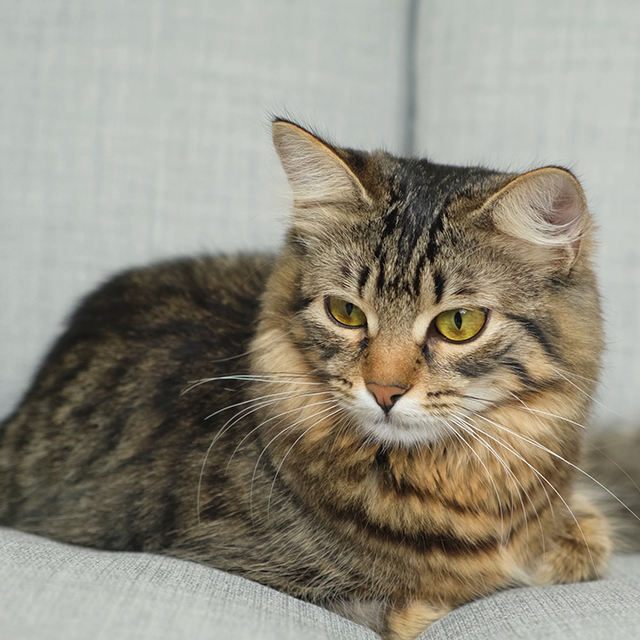

In [ ]:
cat_image = download_image(url="https://static01.nyt.com/images/2024/03/05/autossell/00TB-MEOWS/00TB-MEOWS-square640.jpg", file_name='cat.jpg')
cat_image

## Create resnet model
- See more in https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/
- And here https://pytorch.org/hub/pytorch_vision_resnet/

In [ ]:
def download_state_dict_resnet(url='https://github.com/HODUCVU/Classification-DogvsCat-using-PyTorch-from-Scratch/raw/main/models/ResNet.pth', tar_dir='./models', filename='ResNet.pth'):
  tar_dir = Path(tar_dir)
  tar_dir.mkdir(parents=True, exist_ok=True)
  save_path = tar_dir / filename

  print(f'Downloading {filename}...')
  request = requests.get(url)
  with open(save_path, 'wb') as f:
    f.write(request.content)
  print(f'Model saved to {save_path}')

download_state_dict_resnet(filename='ResNet.pth')

Model saved to models/ResNet50.pth


In [ ]:
!ls /content/models/

ResNet50.pth  ResNet.pth  ResNetv2.pth


In [ ]:
import torch
from torch import nn
import torchvision.models as models
from torchinfo import summary

def create_resnet_model(num_classes:int=2,
                        seed:int=42,
                        state_dict_path=None,
                        device='cuda' if torch.cuda.is_available() else 'cpu'):
  torch.manual_seed(seed)
  if state_dict_path is None:
    # Custom URL for pretrained weights
    pretrained_url = "https://download.pytorch.org/models/resnet50-11ad3fa6.pth"
    # Download the weights
    state_dict = torch.hub.load_state_dict_from_url(pretrained_url, progress=True)
    # Load the ResNet-50 model
    model_resnet = models.resnet50()
    model_resnet.load_state_dict(state_dict)
    # Modify the fully connected layer to have 2 outputs
    num_ftrs = model_resnet.fc.in_features
    model_resnet.fc = torch.nn.Linear(num_ftrs, num_classes)
  else:
    model_resnet = models.resnet50()
    # Modify the fully connected layer to have 2 outputs
    num_ftrs = model_resnet.fc.in_features
    model_resnet.fc = torch.nn.Linear(num_ftrs, num_classes)
    if device == 'cpu':
      model_resnet.load_state_dict(torch.load(state_dict_path, map_location=torch.device('cpu')))
    else:
      model_resnet.load_state_dict(torch.load(state_dict_path))
  # Ensure model is on the correct device
  model_resnet = model_resnet.to(device)
  # model_resnet
  summary(model_resnet, (1, 3, 256, 256))
  return model_resnet

model_resnet = create_resnet_model(state_dict_path='/content/models/ResNet.pth')

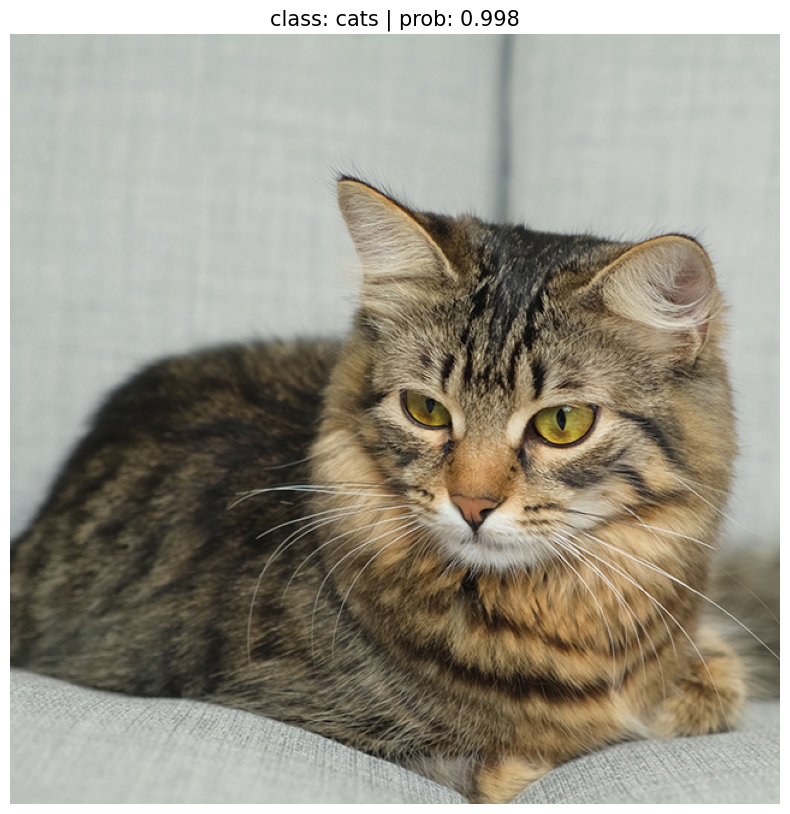

In [ ]:
# test model
make_predict(model_resnet, cat_image, transformer, device)

### train and test. How exciting heyyyy!

In [ ]:
results_model_resnet = train(model=model_resnet, epochs=45, lr=0.0001, train_dataloader=train_dataloader, test_dataloader=test_dataloader, device=device)

In [ ]:
plot_training_and_testing_results(results_model_resnet)

In [ ]:
print(f"Loss values:\nTrain: {results_model_resnet['train_loss'][-1]} | Test: {results_model_resnet['test_loss'][-1]}")
print(f"Accuracy values:\nTrain: {results_model_resnet['train_acc'][-1]} | Test: {results_model_resnet['test_acc'][-1]}")

### Make predict again

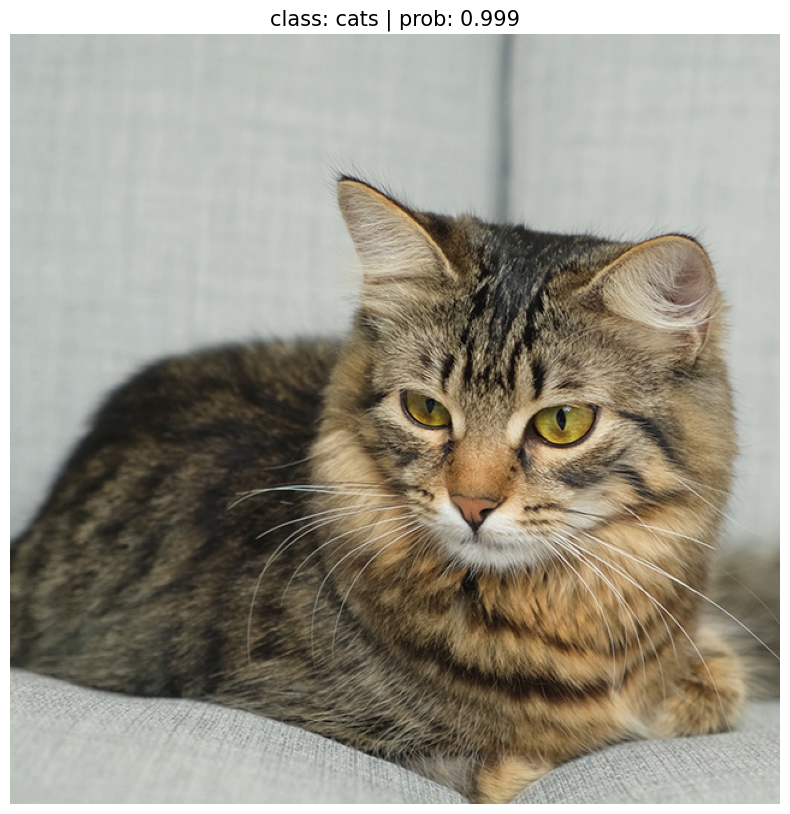

In [ ]:
make_predict(model_resnet, cat_image, transformer, device)

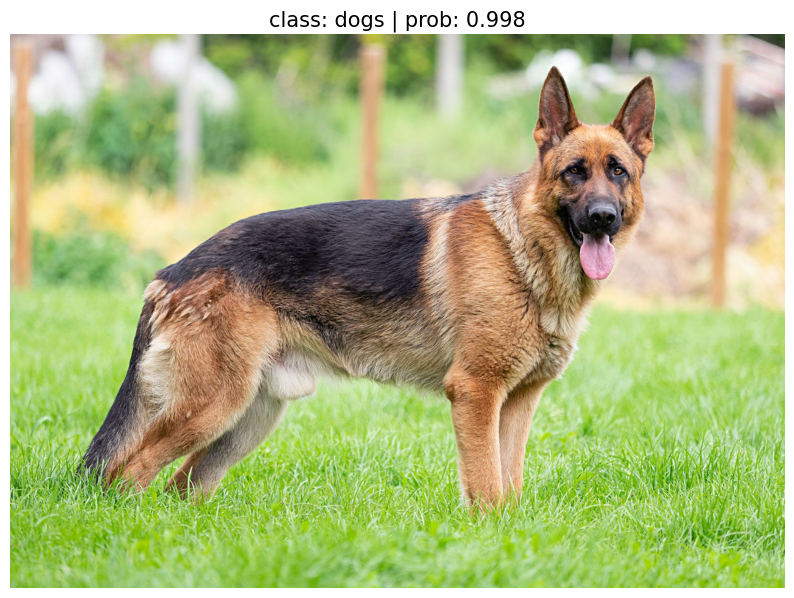

In [ ]:
make_predict(model_resnet, dog_image, transformer, device)

## Compare two models

In [ ]:
import pandas as pd

def compare_models(results_model_0, results_model_1):
  compare_model = pd.DataFrame({'model_0': {"Model name": results_model_0["model_name"],
                                      "Train loss": results_model_0['train_loss'][-1],
                                      "Train Accuracy": results_model_0['train_acc'][-1],
                                      "Test loss": results_model_0['test_loss'][-1],
                                      "Test Accuracy": results_model_0['test_acc'][-1],
                                      "Time training": results_model_0['time_train']},
                          'model_resnet': {"Model name": results_model_1["model_name"],
                                      "Train loss": results_model_1['train_loss'][-1],
                                      "Train Accuracy": results_model_1['train_acc'][-1],
                                      "Test loss": results_model_1['test_loss'][-1],
                                      "Test Accuracy": results_model_1['test_acc'][-1],
                                      "Time training": results_model_1['time_train']}})
  return compare_model

## Save models

In [ ]:
from pathlib import Path
def save_model(model, tar_dir='./models', filename='model.pth'):
  tar_dir = Path(tar_dir)
  tar_dir.mkdir(parents=True, exist_ok=True)
  save_path = tar_dir / filename
  torch.save(obj=model.state_dict(), f=save_path)
  print(f'Model saved to {save_path}')

In [ ]:
# save_model(model_resnet, filename='model_resnet.pth')

# Deploy

## Create functions to deploy model

In [ ]:
def create_resnet_model(num_classes:int=2,
                        seed:int=42):
  # Custom URL for pretrained weights
  pretrained_url = "https://download.pytorch.org/models/resnet50-11ad3fa6.pth"

  # Download the weights
  state_dict = torch.hub.load_state_dict_from_url(pretrained_url, progress=True)
  torch.manual_seed(seed)
  # Load the ResNet-50 model
  model_resnet = models.resnet50()
  model_resnet.load_state_dict(state_dict)
  # Modify the fully connected layer to have 2 outputs
  num_ftrs = model_resnet.fc.in_features
  model_resnet.fc = torch.nn.Linear(num_ftrs, num_classes)
  model_resnet = model_resnet.to(device)
  return model_resnet

In [ ]:
def transform():
  return transforms.Compose([
    transforms.Resize(size=(256,256)),
    transforms.CenterCrop(size=(224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])

In [ ]:
def create_dataloader(train_dir, test_dir, transform, batch_size=32, num_workers=0):
  train_data = DogsvsCatsDataset(train_dir, transform)
  test_data = DogsvsCatsDataset(test_dir, transform)

  train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
  test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)

  classes = train_data.classes
  return train_dataloader, test_dataloader, classes

In [ ]:
from typing import List, Dict
import pathlib
from tqdm import tqdm
from timeit import default_timer as timer
from PIL import Image
import torch
import torchvision

def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transformer: torchvision.transforms,
                   class_names: List[str],
                   device: str = 'cuda' if torch.cuda.is_available() else 'cpu'):
  pred_list = []

  for path in tqdm(paths):
    pred_dict = {}
    pred_dict['image_path'] = path
    class_name = path.parent.stem
    pred_dict['class_name'] = class_name

    start_time = timer()
    image = Image.open(path)
    transformed_image = transformer(image).unsqueeze(0).to(device)

    model.to(device)
    model.eval()
    with torch.inference_mode():
      y_pred = model(transformed_image)
      prob = torch.softmax(y_pred, dim=1)
      pred_label = torch.argmax(prob, dim=1)
      pred_class = class_names[pred_label.cpu()]

      # Make sure dictionary are on CPU
      pred_dict['prod_pred'] = round(prob.unsqueeze(0).cpu().max().item(), 4)
      pred_dict['pred_class'] = pred_class

      end_time = timer()
      pred_dict['time_for_pred'] = round(end_time - start_time, 4)

    pred_dict['correct'] = class_name == pred_class
    pred_list.append(pred_dict)
  return pred_list

## Checking the size of models feature extractor

In [ ]:
from pathlib import Path

resnet_model_size = Path("/content/models/ResNet.pth").stat().st_size // (1024*1024)
print(f'ResNet feature extractor model size: {resnet_model_size} MB')

ResNet feature extractor model size: 89 MB


In [ ]:
# nums of paramenters
def count_parameters(model):
  return sum(torch.numel(p) for p in model.parameters())

resnet_total_params = count_parameters(model_resnet)
print(f'Total parameters of {model_resnet.__class__.__name__} is {resnet_total_params}')

Total parameters of ResNet is 23512130


In [ ]:
# resnet_stat = {'test_loss': results_model_resnet['test_loss'][-1],
#                'test_acc': results_model_resnet['test_acc'][-1],
#                'number_of_parameters': resnet_total_params,
#                'model_size (MB)': resnet_model_size}
# resnet_stat

In [ ]:
resnet_stat = {'test_loss': 0.02,
               'test_acc': 0.98,
               'number_of_parameters': resnet_total_params,
               'model_size (MB)': resnet_model_size}
resnet_stat

{'test_loss': 0.02,
 'test_acc': 0.98,
 'number_of_parameters': 23512130,
 'model_size (MB)': 89}

## Make predict on CPU and measure time of predict progress

### Load models

In [ ]:
device_cpu = 'cpu'

In [ ]:
from pathlib import Path

test_data_paths = list(Path(test_dir).glob('*/*.jpg'))
test_data_paths[:5]

[PosixPath('data/dogvscat/validation/cats/cat.2234.jpg'),
 PosixPath('data/dogvscat/validation/cats/cat.2253.jpg'),
 PosixPath('data/dogvscat/validation/cats/cat.2230.jpg'),
 PosixPath('data/dogvscat/validation/cats/cat.2473.jpg'),
 PosixPath('data/dogvscat/validation/cats/cat.2121.jpg')]

In [ ]:
resnet_test_pred_dicts = pred_and_store(paths=test_data_paths, model=model_resnet, transformer=transformer, class_names=train_data.classes, device=device_cpu)

100%|██████████| 1000/1000 [03:49<00:00,  4.35it/s]


In [ ]:
import pandas as pd

resnet_test_pred_df = pd.DataFrame(resnet_test_pred_dicts)
resnet_test_pred_df.head()

image_path class_name  prod_pred  \
0  data/dogvscat/validation/cats/cat.2234.jpg       cats     0.9998   
1  data/dogvscat/validation/cats/cat.2253.jpg       cats     0.9983   
2  data/dogvscat/validation/cats/cat.2230.jpg       cats     0.9989   
3  data/dogvscat/validation/cats/cat.2473.jpg       cats     0.9979   
4  data/dogvscat/validation/cats/cat.2121.jpg       cats     0.9994   

  pred_class  time_for_pred  correct  
0       cats         0.3300     True  
1       cats         0.3074     True  
2       cats         0.2978     True  
3       cats         0.2074     True  
4       cats         0.2025     True

In [ ]:
resnet_test_pred_df.correct.value_counts()

correct
True     989
False     11
Name: count, dtype: int64

In [ ]:
resnet_test_pred_df_average_time_per_pred = round(resnet_test_pred_df.time_for_pred.mean(), 4)
print(f'Average time for predict on CPU is {resnet_test_pred_df_average_time_per_pred} seconds')

Average time for predict on CPU is 0.2272 seconds


In [ ]:
resnet_stat['time_per_pred_cpu'] = resnet_test_pred_df_average_time_per_pred
resnet_stat

{'test_loss': 0.02,
 'test_acc': 0.98,
 'number_of_parameters': 23512130,
 'model_size (MB)': 89,
 'time_per_pred_cpu': 0.2272}

In [ ]:
# resnet_test_pred_dicts_on_gpu = pred_and_store(paths=test_data_paths, model=model_resnet, transformer=transformer, class_names=train_data.classes)

100%|██████████| 1000/1000 [00:22<00:00, 43.61it/s]


In [ ]:
# resnet_test_pred_on_gpu_df = pd.DataFrame(resnet_test_pred_dicts_on_gpu)
# resnet_test_pred_on_gpu_df.head()

image_path class_name  prod_pred  \
0  data/dogvscat/validation/cats/cat.2388.jpg       cats     0.9897   
1  data/dogvscat/validation/cats/cat.2218.jpg       cats     0.9997   
2  data/dogvscat/validation/cats/cat.2154.jpg       cats     0.9975   
3  data/dogvscat/validation/cats/cat.2412.jpg       cats     0.9998   
4  data/dogvscat/validation/cats/cat.2137.jpg       cats     1.0000   

  pred_class  time_for_pred  correct  
0       cats         0.1420     True  
1       cats         0.0225     True  
2       cats         0.0218     True  
3       cats         0.0238     True  
4       cats         0.0215     True

In [ ]:
# resnet_test_pred_on_gpu_df.correct.value_counts()

correct
True     992
False      8
Name: count, dtype: int64

In [ ]:
# resnet_test_pred_df_average_time_per_pred_on_gpu = round(resnet_test_pred_on_gpu_df.time_for_pred.mean(), 4)
# print(f'Average time for predict on CPU is {resnet_test_pred_df_average_time_per_pred_on_gpu} seconds')

Average time for predict on CPU is 0.0223 seconds


In [ ]:
# resnet_stat['time_per_pred_gpu'] = resnet_test_pred_df_average_time_per_pred_on_gpu
# resnet_stat

{'test_loss': 0.01750398790863983,
 'test_acc': 0.9931640625,
 'number_of_parameters': 23512130,
 'model_size (MB)': 89,
 'time_per_pred_cpu': 0.1886,
 'time_per_pred_gpu': 0.0223}

## Visualize stats

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(resnet_stat, index=[0])
# Add column for model names
df["model"] = ["ResNet"]
df["test_acc"] = round(df["test_acc"] * 100, 2)
df


test_loss  test_acc  number_of_parameters  model_size (MB)  \
0       0.02      98.0              23512130               89   

   time_per_pred_cpu   model  
0             0.2272  ResNet

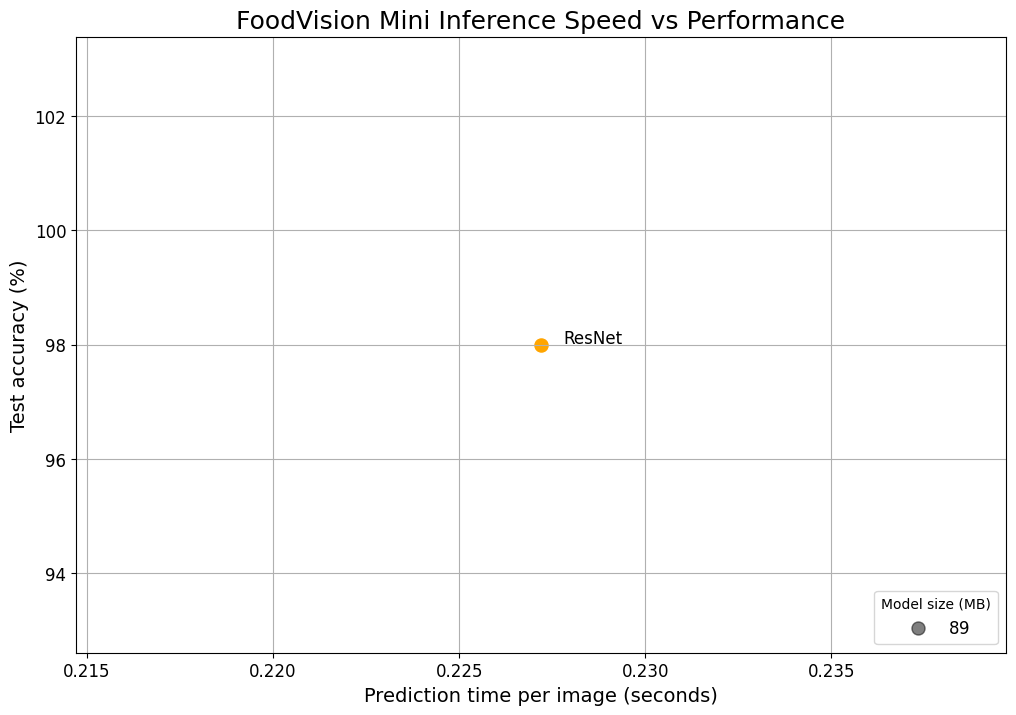

In [ ]:
# 1. Create a plot from model comparison DataFrame
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(data=df,
                     x="time_per_pred_cpu",
                     y="test_acc",
                     c=["orange"], # what colours to use?
                     s="model_size (MB)") # size the dots by the model sizes

# 2. Add titles, labels and customize fontsize for aesthetics
ax.set_title("FoodVision Mini Inference Speed vs Performance", fontsize=18)
ax.set_xlabel("Prediction time per image (seconds)", fontsize=14)
ax.set_ylabel("Test accuracy (%)", fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.grid(True)

# 3. Annotate with model names
for index, row in df.iterrows():
    ax.annotate(text=row["model"], # note: depending on your version of Matplotlib, you may need to use "s=..." or "text=...", see: https://github.com/faustomorales/keras-ocr/issues/183#issuecomment-977733270
                xy=(row["time_per_pred_cpu"]+0.0006, row["test_acc"]+0.03),
                size=12)

# 4. Create a legend based on model sizes
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.5)
model_size_legend = ax.legend(handles,
                              labels,
                              loc="lower right",
                              title="Model size (MB)",
                              fontsize=12)

# Save the figure
images_save_path = Path("images")
images_save_path.mkdir(parents=True, exist_ok=True)
plt.savefig("images/09-foodvision-mini-inference-speed-vs-performance.jpg")

# Show the figure
plt.show()

# Gradio demo

In [ ]:
try:
  import gradio as gr
except:
  !pip install -q gradio
  import gradio as gr

print(gr.__version__)

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 57.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.2/318.2 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 66.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.2/92.2 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━

In [ ]:
model_resnet.to('cpu')
next(iter(model_resnet.parameters())).device

device(type='cpu')

In [ ]:
def predict(image):
  start_time = timer()

  image = transformer(image).unsqueeze(0)
  class_names = train_data.classes
  model_resnet.eval()
  model_resnet.to('cpu')
  with torch.inference_mode():
    y_pred = model_resnet(image)
    probs = torch.softmax(y_pred, dim=1)
  # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
  pred_labels_and_probs = {class_names[i]: float(probs[0][i]) for i in range(len(class_names))}
  pred_time = round(timer() - start_time, 4)
  return pred_labels_and_probs, pred_time

In [ ]:
import random
from PIL import Image

test_data_paths = list(Path(test_dir).glob('*/*.jpg'))
random_image_path = random.sample(test_data_paths, k=1)[0]
image = Image.open(random_image_path)
print(random_image_path)
pred_dict, pred_time = predict(image)
print(pred_dict)
print(pred_time)


data/dogvscat/validation/cats/cat.2330.jpg
{'cats': 0.9989784955978394, 'dogs': 0.0010214867070317268}
0.2408


## Creating a list of example images

In [ ]:
# Create a list of example inputs to our Gradio demo
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)]
example_list

[['data/dogvscat/validation/dogs/dog.2336.jpg'],
 ['data/dogvscat/validation/dogs/dog.2399.jpg'],
 ['data/dogvscat/validation/cats/cat.2382.jpg']]

## Building a Gradio interface

In [ ]:
title = "Dogs and Cats Mini"
title = title + "   ≽^•⩊•^≼   " + " ♡  " + "   ૮₍´｡ᵔ ꈊ ᵔ｡`₎ა    "
title

'Dogs and Cats Mini   ≽^•⩊•^≼    ♡     ૮₍´｡ᵔ ꈊ ᵔ｡`₎ა    '

In [ ]:
import gradio as gr

# Create title, description and article strings
title = "Dogs and Cats Mini"
title = title + "   ≽^•⩊•^≼   " + " ♡  " + "   ૮₍´｡ᵔ ꈊ ᵔ｡`₎ა    "

description = "An ResNet50 feature extractor computer vision model to classify images of animals as dog and cat."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch(debug=False, # print errors locally?
            share=True) # generate a publically shareable URL?

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://edf3508d3c2e17d97b.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


# Push on hugginface.com

In [ ]:
import shutil
from pathlib import Path

# Create FoodVision mini demo path
dogvscat_mini_demo_path = Path("demos/dogvscat_mini/")

# Remove files that might already exist there and create new directory
if dogvscat_mini_demo_path.exists():
    shutil.rmtree(dogvscat_mini_demo_path)
    dogvscat_mini_demo_path.mkdir(parents=True, # make the parent folders?
                                    exist_ok=True) # create it even if it already exists?
else:
    # If the file doesn't exist, create it anyway
    dogvscat_mini_demo_path.mkdir(parents=True,
                                    exist_ok=True)

# Check what's in the folder
!ls demos/dogvscat_mini/

In [ ]:
import shutil
from pathlib import Path

# 1. Create an examples directory
dogvscat_mini_examples_path = dogvscat_mini_demo_path / "examples"
dogvscat_mini_examples_path.mkdir(parents=True, exist_ok=True)

# 2. Collect three random test dataset image paths
dogvscat_examples = [Path('/content/data/dogvscat/validation/dogs/dog.2000.jpg'),
                            Path('/content/data/dogvscat/validation/dogs/dog.2063.jpg'),
                            Path('/content/data/dogvscat/validation/cats/cat.2015.jpg')]

# 3. Copy the three random images to the examples directory
for example in dogvscat_examples:
    destination = dogvscat_mini_examples_path / example.name
    print(f"[INFO] Copying {example} to {destination}")
    shutil.copy2(src=example, dst=destination)

[INFO] Copying /content/data/dogvscat/validation/dogs/dog.2000.jpg to demos/dogvscat_mini/examples/dog.2000.jpg
[INFO] Copying /content/data/dogvscat/validation/dogs/dog.2063.jpg to demos/dogvscat_mini/examples/dog.2063.jpg
[INFO] Copying /content/data/dogvscat/validation/cats/cat.2015.jpg to demos/dogvscat_mini/examples/cat.2015.jpg


In [ ]:
import os

# Get example filepaths in a list of lists
example_list = [["examples/" + example] for example in os.listdir(dogvscat_mini_examples_path)]
example_list

[['examples/dog.2063.jpg'],
 ['examples/dog.2000.jpg'],
 ['examples/cat.2015.jpg']]

In [ ]:
import shutil

# Create a source path for our target model
resnet_dogvscat_mini_model_path = "models/ResNet.pth"

# Create a destination path for our target model
resnet_dogvscat_mini_model_destination = dogvscat_mini_demo_path / resnet_dogvscat_mini_model_path.split("/")[1]

# Try to move the file
try:
    print(f"[INFO] Attempting to move {resnet_dogvscat_mini_model_path} to {resnet_dogvscat_mini_model_destination}")

    # Move the model
    shutil.move(src=resnet_dogvscat_mini_model_path,
                dst=resnet_dogvscat_mini_model_destination)

    print(f"[INFO] Model move complete.")

# If the model has already been moved, check if it exists
except:
    print(f"[INFO] No model found at {resnet_dogvscat_mini_model_path}, perhaps its already been moved?")
    print(f"[INFO] Model exists at {resnet_dogvscat_mini_model_destination}: {resnet_dogvscat_mini_model_destination.exists()}")

[INFO] Attempting to move models/ResNet.pth to demos/dogvscat_mini/ResNet.pth
[INFO] Model move complete.


## Write Python script

In [ ]:
%%writefile demos/dogvscat_mini/model.py

def create_resnet_model(num_classes:int=2,
                        seed:int=42):
  torch.manual_seed(seed)
  # Load the ResNet-50 model
  model_resnet = models.resnet50()
  # Modify the fully connected layer to have 2 outputs
  num_ftrs = model_resnet.fc.in_features
  model_resnet.fc = torch.nn.Linear(num_ftrs, num_classes)
  model_resnet = model_resnet.to(device)
  transforms.Compose([
    transforms.Resize(size=(256,256)),
    transforms.CenterCrop(size=(224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])
  return model_resnet, transforms

Overwriting demos/dogvscat_mini/model.py


In [ ]:
%%writefile demos/dogvscat_mini/app.py

import gradio as gr
import os
import torch

from model import create_resnet_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
class_names = ['dog', 'cat']

# Create model
resnet50, resnet50_transforms = create_resnet_model(num_classes=2,
                                                    seed=42)

# load saved weights
resnet50.load_state_dict(torch.load(f="ResNet.pth", map_location=torch.device("cpu")))

# Predict function
def predict(img):

  start_time = timer()

  img = resnet50_transforms(img).unsqueeze(0)

  resnet50.eval()
  with torch.inference_mode():
    pred_probs = torch.softmax(resnet50(img), dim=1)
  pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_name))}

  pred_time = round(timer() - start_time, 4)
  return pred_labels_and_probs, pred_time

# Gradio app
# Create title, description and article strings
title = "Dogs and Cats Mini"
title = title + "   ≽^•⩊•^≼   " + " ♡  " + "   ૮₍´｡ᵔ ꈊ ᵔ｡`₎ა    "

description = "An ResNet50 feature extractor computer vision model to classify images of animals as dog and cat."

example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create the Gradio demo
demo = gr.Interface(fn=predict,
                    inputs=gr.Image(type='pil'),
                    outputs=[gr.Label(num_top_classes=2, label="Predictions"),
                             gr.Number(label="Prediction time (s)")],
                    # Create examples list
                    examples=example_list,
                    title=title,
                    descriptioon=description)

# Launch the demo!
demo.launch()

Writing demos/dogvscat_mini/app.py


In [ ]:
gr.__version__, torch.__version__, torchvision.__version__

In [ ]:
%%writefile demos/dogvscat_mini/requirements.txt
gradio>=4.39.0
torchvision>=0.18.1
torch>=2.3.1

Writing demos/dogvscat_mini/requirements.txt


In [ ]:
!ls demos/dogvscat_mini

app.py	examples  model.py  requirements.txt  ResNet.pth


In [ ]:
# Change into and then zip the foodvision_mini folder but exclude certain files
!cd demos/dogvscat_mini && zip -r ../dogvscat_mini.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"


  adding: app.py (deflated 52%)
  adding: examples/ (stored 0%)
  adding: examples/dog.2063.jpg (deflated 1%)
  adding: examples/dog.2000.jpg (deflated 1%)
  adding: examples/cat.2015.jpg (deflated 2%)
  adding: model.py (deflated 49%)
  adding: requirements.txt (deflated 8%)
  adding: ResNet.pth (deflated 7%)


In [ ]:
from google.colab import files
files.download("demos/dogvscat_mini.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>